In this project, I will show how to work with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, I will explore how to develop a simple shallow autoencoder, then I will develop a deep version. Finally, I will experiment with the application of autoencoder on denoising data task (denoising-autoencoder).

In [ ]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 84.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchdata to determine which version is compatible wi

#Imports

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

I load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing.

First, I will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but I will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. I will normalize all values between $0$ and $1$, and I will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, I split the train set in a validation set and a new test set.
Finally, I will design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [ ]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [ ]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [ ]:
noise_factor = 0.1

# SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In [ ]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

In [ ]:
device = torch.device("cpu") #for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

In [ ]:
ENCODING_DIM = 250

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

In [ ]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00155
Test mse: 0.00159


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

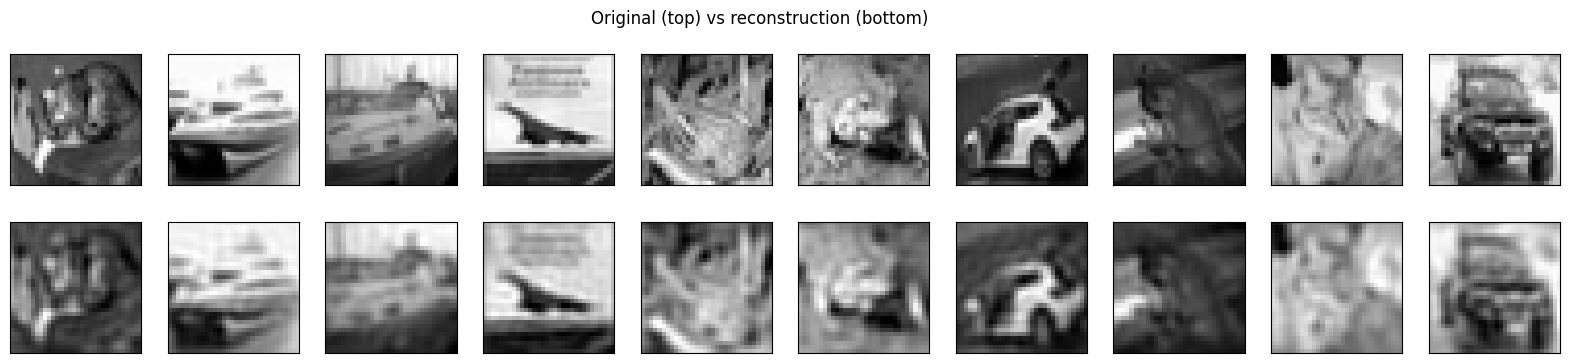

In [ ]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")

# Shallow Linear Autoencoder

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.1

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

In [ ]:
class Auto_Encoder(nn.Module):

  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))

      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer

    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()

  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'linear'
lr = 0.005
epochs = 30

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())

    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.84045458 ---------------- Val_Acc: Val_Loss: 0.23911570
epoch: 2 -> Loss: 0.18196887 ---------------- Val_Acc: Val_Loss: 0.14172712
epoch: 3 -> Loss: 0.11627389 ---------------- Val_Acc: Val_Loss: 0.09783618
epoch: 4 -> Loss: 0.08284553 ---------------- Val_Acc: Val_Loss: 0.07250074
epoch: 5 -> Loss: 0.06366219 ---------------- Val_Acc: Val_Loss: 0.05649882
epoch: 6 -> Loss: 0.04991399 ---------------- Val_Acc: Val_Loss: 0.04546920
epoch: 7 -> Loss: 0.04108632 ---------------- Val_Acc: Val_Loss: 0.03788039
epoch: 8 -> Loss: 0.03434360 ---------------- Val_Acc: Val_Loss: 0.03207023
epoch: 9 -> Loss: 0.02927423 ---------------- Val_Acc: Val_Loss: 0.02757825
epoch: 10 -> Loss: 0.02534838 ---------------- Val_Acc: Val_Loss: 0.02407517
epoch: 11 -> Loss: 0.02225120 ---------------- Val_Acc: Val_Loss: 0.02126027
epoch: 12 -> Loss: 0.01976905 ---------------- Val_Acc: Val_Loss: 0.01902839
epoch: 13 -> Loss: 0.01774061 ---------------- Val_Acc: Val_Loss: 0.01722409
epoch: 1

In [ ]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

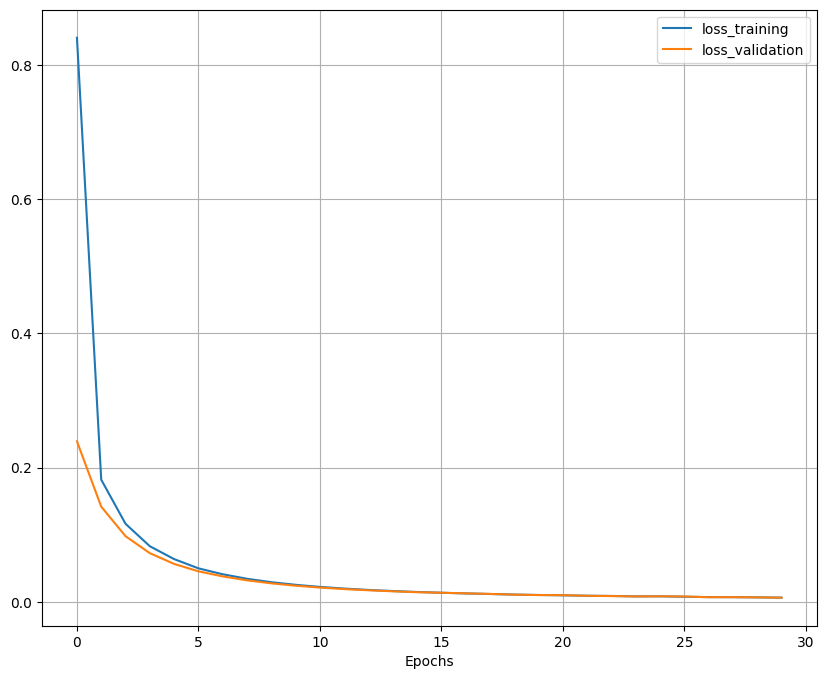

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [ ]:
test(Shallow_AE)

Test Loss: 0.00611056


In [ ]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

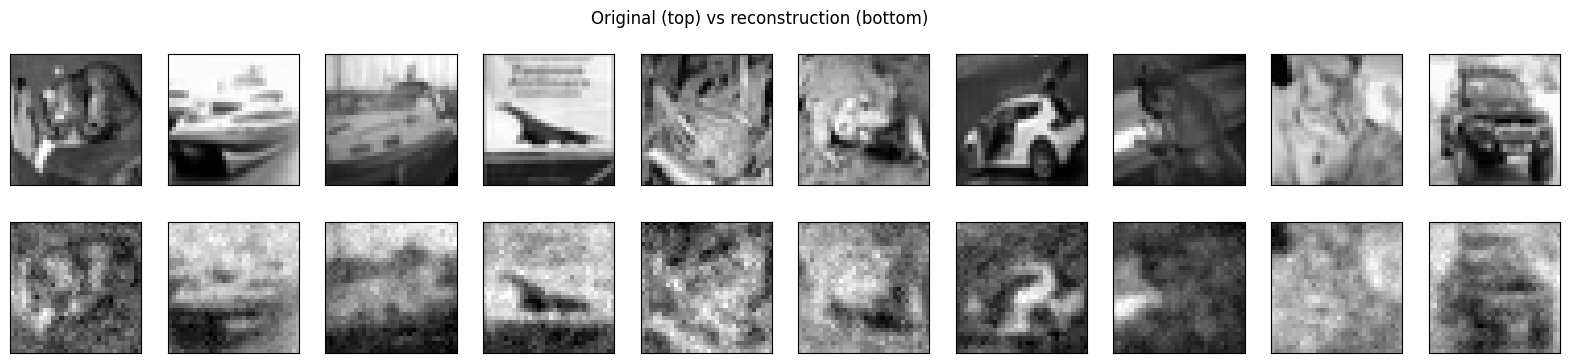

In [ ]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

# Shallow non-linear Autoencoder

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 30

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04060944 ---------------- Val_Acc: Val_Loss: 0.02716812
epoch: 2 -> Loss: 0.02164552 ---------------- Val_Acc: Val_Loss: 0.01796570
epoch: 3 -> Loss: 0.01704806 ---------------- Val_Acc: Val_Loss: 0.01524699
epoch: 4 -> Loss: 0.01405513 ---------------- Val_Acc: Val_Loss: 0.01343055
epoch: 5 -> Loss: 0.01266835 ---------------- Val_Acc: Val_Loss: 0.01276445
epoch: 6 -> Loss: 0.01149697 ---------------- Val_Acc: Val_Loss: 0.01043952
epoch: 7 -> Loss: 0.01081039 ---------------- Val_Acc: Val_Loss: 0.01020679
epoch: 8 -> Loss: 0.00980224 ---------------- Val_Acc: Val_Loss: 0.00914854
epoch: 9 -> Loss: 0.00946453 ---------------- Val_Acc: Val_Loss: 0.00890246
epoch: 10 -> Loss: 0.00926109 ---------------- Val_Acc: Val_Loss: 0.00897887
epoch: 11 -> Loss: 0.00869816 ---------------- Val_Acc: Val_Loss: 0.00839526
epoch: 12 -> Loss: 0.00844521 ---------------- Val_Acc: Val_Loss: 0.00788062
epoch: 13 -> Loss: 0.00828759 ---------------- Val_Acc: Val_Loss: 0.00791114
epoch: 1

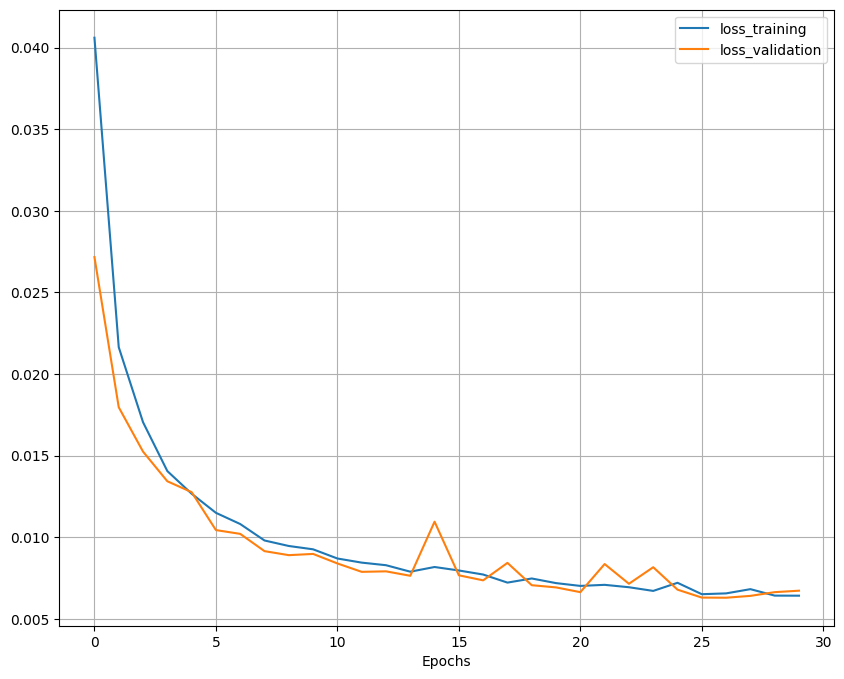

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(Shallow_non_AE)

Test Loss: 0.00672817


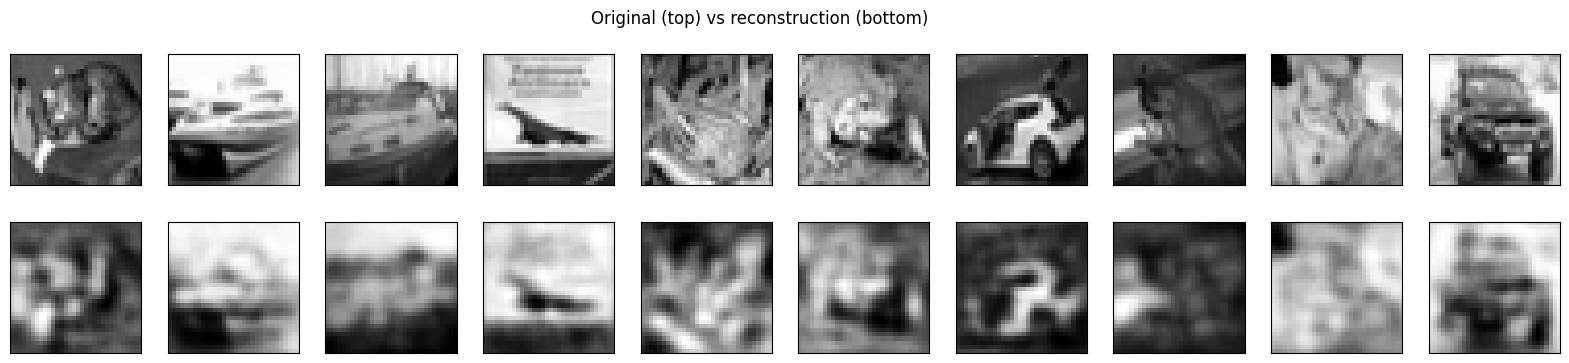

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [1024,512,256]
DEC_LAYERS = [512,1024]
ACT_FUN = 'leaky_relu'
lr = 0.001
epochs = 45
# END

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 1024]               1,049,600
│    └─Linear: 2-2                       [512, 512]                524,800
│    └─Linear: 2-3                       [512, 256]                131,328
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 512]                131,584
│    └─Linear: 2-5                       [512, 1024]               525,312
│    └─Linear: 2-6                       [512, 1024]               1,049,600
Total params: 3,412,224
Trainable params: 3,412,224
Non-trainable params: 0
Total mult-adds (G): 1.75
Input size (MB): 2.10
Forward/backward pass size (MB): 17.83
Params size (MB): 13.65
Estimated Total Size (MB): 33.57

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.06726476 ---------------- Val_Acc: Val_Loss: 0.03557137
epoch: 2 -> Loss: 0.02881081 ---------------- Val_Acc: Val_Loss: 0.02455403
epoch: 3 -> Loss: 0.02229989 ---------------- Val_Acc: Val_Loss: 0.02137877
epoch: 4 -> Loss: 0.01885405 ---------------- Val_Acc: Val_Loss: 0.01771361
epoch: 5 -> Loss: 0.01701596 ---------------- Val_Acc: Val_Loss: 0.01590319
epoch: 6 -> Loss: 0.01546911 ---------------- Val_Acc: Val_Loss: 0.01473001
epoch: 7 -> Loss: 0.01461639 ---------------- Val_Acc: Val_Loss: 0.01395401
epoch: 8 -> Loss: 0.01351951 ---------------- Val_Acc: Val_Loss: 0.01324829
epoch: 9 -> Loss: 0.01330412 ---------------- Val_Acc: Val_Loss: 0.01259940
epoch: 10 -> Loss: 0.01227061 ---------------- Val_Acc: Val_Loss: 0.01201080
epoch: 11 -> Loss: 0.01174221 ---------------- Val_Acc: Val_Loss: 0.01156171
epoch: 12 -> Loss: 0.01135548 ---------------- Val_Acc: Val_Loss: 0.01110919
epoch: 13 -> Loss: 0.01127795 ---------------- Val_Acc: Val_Loss: 0.01109153
epoch: 1

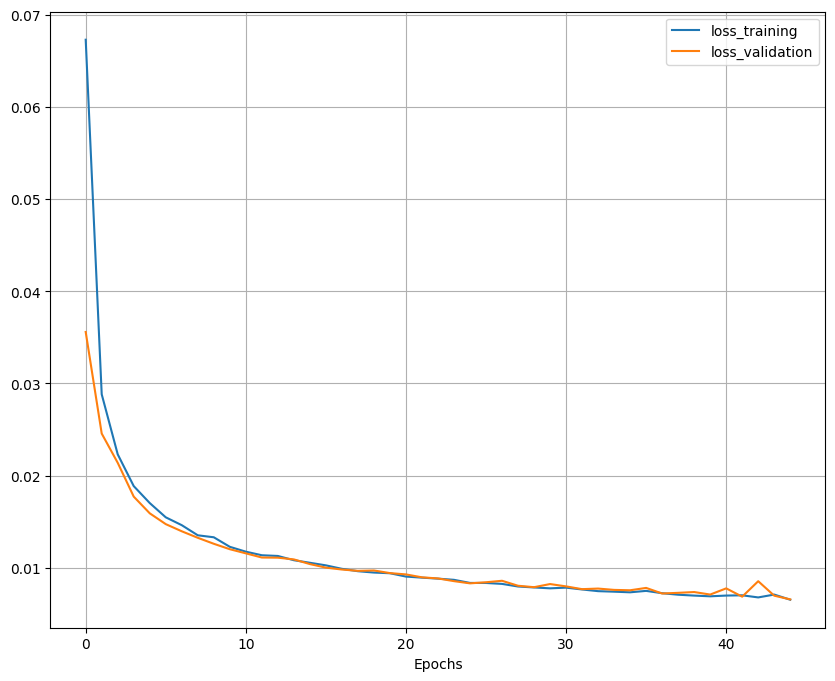

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(DEEP_non_AE)

Test Loss: 0.00657227


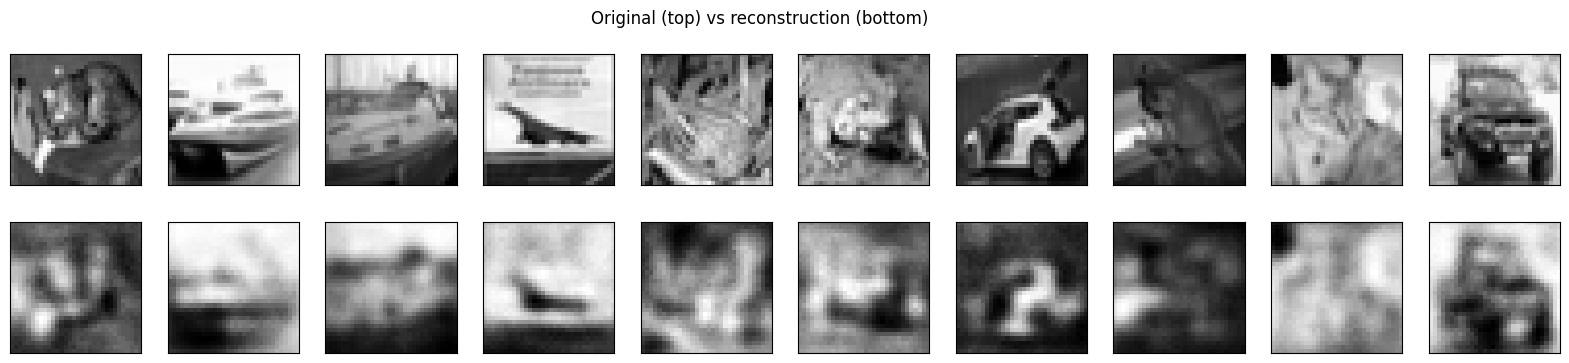

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

# Shallow Denoising Autoencoder

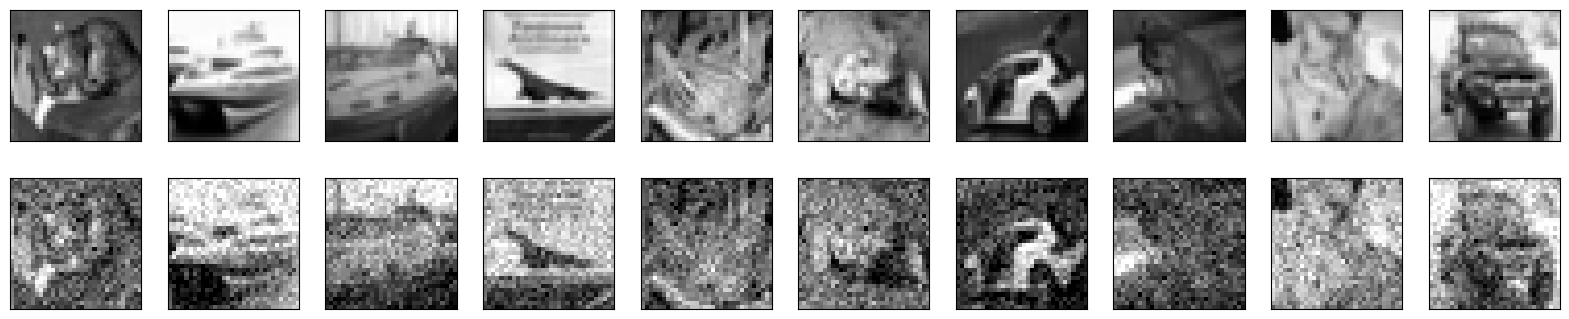

In [ ]:
plot_img(10, [x_test, x_test_noisy])

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [1024,512,256]
DEC_LAYERS = [512,1024]
ACT_FUN = 'leaky_relu'
lr = 0.001
epochs = 50
# END

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 1024]               1,049,600
│    └─Linear: 2-2                       [512, 512]                524,800
│    └─Linear: 2-3                       [512, 256]                131,328
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 512]                131,584
│    └─Linear: 2-5                       [512, 1024]               525,312
│    └─Linear: 2-6                       [512, 1024]               1,049,600
Total params: 3,412,224
Trainable params: 3,412,224
Non-trainable params: 0
Total mult-adds (G): 1.75
Input size (MB): 2.10
Forward/backward pass size (MB): 17.83
Params size (MB): 13.65
Estimated Total Size (MB): 33.57

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True) #[TO COMPLETE]

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.06537516 ---------------- Val_Acc: Val_Loss: 0.03356610
epoch: 2 -> Loss: 0.02863071 ---------------- Val_Acc: Val_Loss: 0.02485084
epoch: 3 -> Loss: 0.02223581 ---------------- Val_Acc: Val_Loss: 0.02037043
epoch: 4 -> Loss: 0.01898305 ---------------- Val_Acc: Val_Loss: 0.01777750
epoch: 5 -> Loss: 0.01754854 ---------------- Val_Acc: Val_Loss: 0.01724372
epoch: 6 -> Loss: 0.01594983 ---------------- Val_Acc: Val_Loss: 0.02275139
epoch: 7 -> Loss: 0.01511524 ---------------- Val_Acc: Val_Loss: 0.01437966
epoch: 8 -> Loss: 0.01404758 ---------------- Val_Acc: Val_Loss: 0.01441633
epoch: 9 -> Loss: 0.01385724 ---------------- Val_Acc: Val_Loss: 0.01372253
epoch: 10 -> Loss: 0.01284651 ---------------- Val_Acc: Val_Loss: 0.01256747
epoch: 11 -> Loss: 0.01239352 ---------------- Val_Acc: Val_Loss: 0.01220833
epoch: 12 -> Loss: 0.01216471 ---------------- Val_Acc: Val_Loss: 0.01189285
epoch: 13 -> Loss: 0.01185209 ---------------- Val_Acc: Val_Loss: 0.01139804
epoch: 1

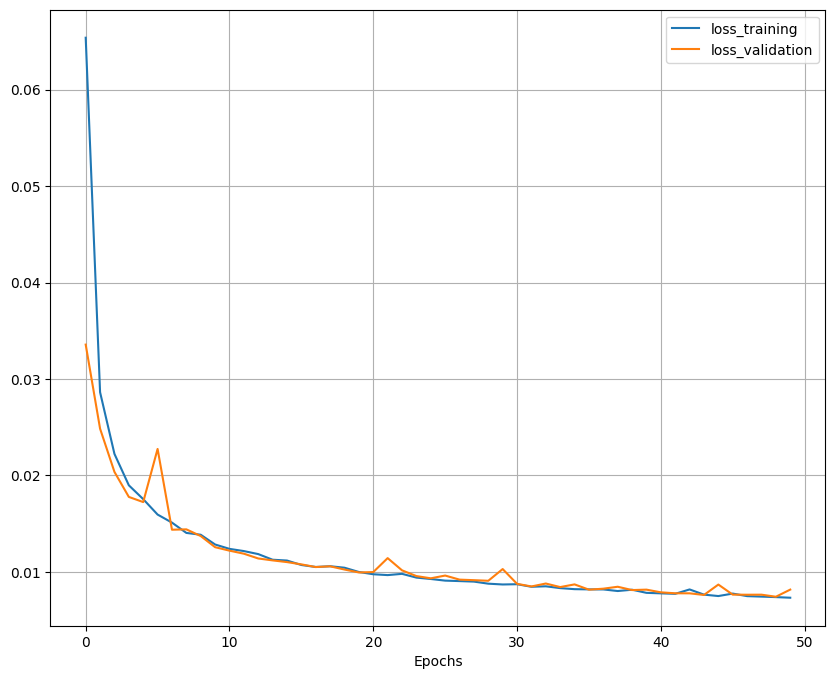

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00814399


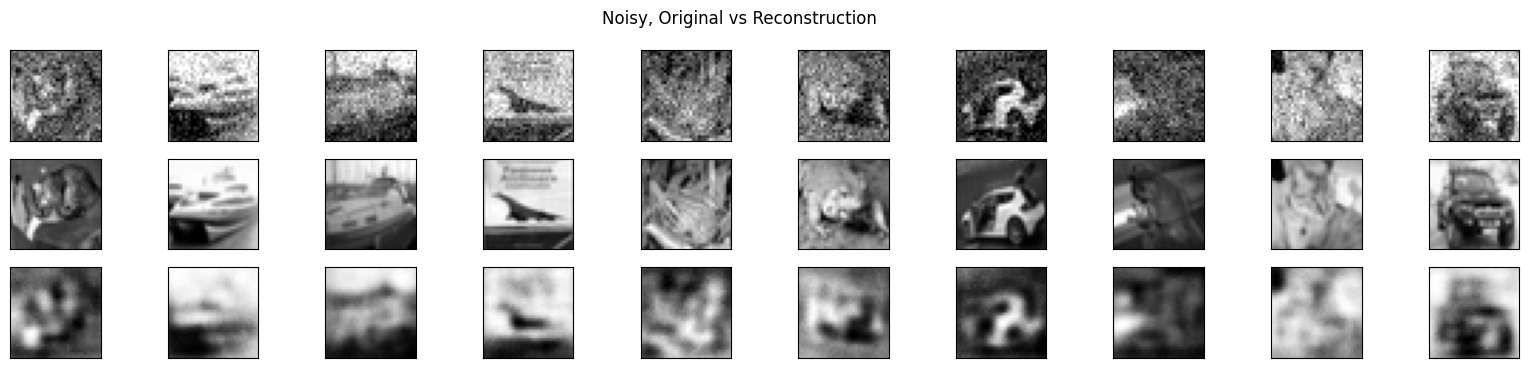

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")